# 1. Create Training and testing sets
## Prepare the libaries and data
Prepare libraries used in the environment.

In [3]:
# Install libraries
!pip install rasterio
!pip install numpy
!pip install matplotlib

In [4]:
# Import libraries
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask

## Mask Shallow Water Area

This step can be done in QGIS using the following process:

1. **Create NDWI** using the raster calculator:
   - Formula: `(green - nir) / (green + nir)`
   - **Note** for PlanetScope images:
     - Green = Band 4
     - NIR = Band 8

2. **Reclassify NDWI** into two categories:
   - If NDWI > 0, it represents shallow water.
   - If NDWI < 0, it represents deep water or land.

3. **Convert to vector format** and delete the land areas.

4. **Use the vector layer** to mask the original raster.


After the original raster data is masked, load data to the environment. <br>
Check the shape of the data, it will show bands, row and column on the console.

## Create Descriptions from the Raster Data
Create descriptions for the bands in the image data, which will later be associated as a dictionary with specific bands (e.g., "Band 1" has the description "B1," etc.). <br>  

Additionally, we will reshape or adjust the dimensions of the raster data to simplify identification later.  

In [5]:
# Load raster data
raster_path = r"Data\Masked_PS Gili - 8 Juli 2024.tif" # Your raster directory
dataset = rasterio.open(raster_path)

# Get the shape of the raster data
planetscope = dataset.read()
print(f"{planetscope.shape} - Band, Row and Column")

(8, 1289, 2383) - Band, Row and Column


Change the shape of the data with `transpose`, so the shape becomes row, column and band.

In [6]:
# Change the data shape with `.transpose`
planetscope = planetscope.transpose(1, 2, 0)
print(f"{planetscope.shape} - Row, Column and Band")

(1289, 2383, 8) - Row, Column and Band


In [7]:
# Retrieve the list of band descriptions from the dataset
desc = dataset.descriptions

# If descriptions are not available, create manual descriptions
if not desc or all(d is None for d in desc):
    desc = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8"]

# Create a dictionary to associate band descriptions with their indices after transpose
band_descriptions = {f"Band {i+1}": desc[i] for i in range(len(desc))}

# Display the dimensions and descriptions for each band
print("\nDimensions of the raster data after transpose:", planetscope.shape)
print("Descriptions for each band after transpose:")
for band, description in band_descriptions.items():
    print(f'{band}: {description}')



Dimensions of the raster data after transpose: (1289, 2383, 8)
Descriptions for each band after transpose:
Band 1: B1
Band 2: B2
Band 3: B3
Band 4: B4
Band 5: B5
Band 6: B6
Band 7: B7
Band 8: B8


### Export the Raster Data  
Export the data, which has been described for each band, into a `tif` format while retaining the metadata with `meta.copy()` from the original data.

In [8]:
# Band descriptions for the Planetscope image (already defined above)
band_descriptions = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']

# Path to save the output TIFF file
output_path = r"Data\Masked_PS_Gili_with_descriptions.tif"

# Copy metadata from the original dataset and update with the number of bands and data type
meta = dataset.meta.copy()
meta.update({
    "count": planetscope.shape[2],  # Number of bands in transposed data (*remember: rows, columns, bands)
    "dtype": planetscope.dtype     # Data type of the array
})

# Export the Planetscope image with band descriptions
with rasterio.open(output_path, 'w', **meta) as dst:
    for i in range(planetscope.shape[2]):
        dst.write(planetscope[:, :, i], i + 1)  # Write each band to the file
        dst.set_band_description(i + 1, band_descriptions[i])  # Add band description

# Make sure the result
with rasterio.open(output_path) as planetscope_check:
    desc = planetscope_check.descriptions
    print(f'Raster description: {desc}\n')


Raster description: ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8')



### Plot the map  
Create a map plot to visualize the data with a true color composite from PlanetScope.

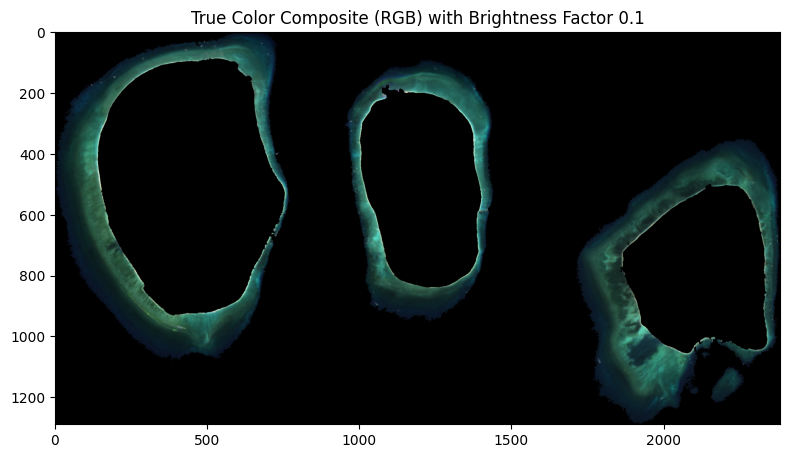

In [9]:
# Set brightness factor for the composite
brightness_factor = 0.1  # Change this value between 0 and 1 to reduce brightness (e.g., 0.5 for half brightness)

# Create a single map plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create true color composite using Bands 6 (Red), 4 (Green), and 2 (Blue)
true_color_composite = np.stack([planetscope[:, :, 5], planetscope[:, :, 3], planetscope[:, :, 1]], axis=2)  # Band 6, 4, 2 (Python number start from 0)
true_color_composite = np.clip(true_color_composite * brightness_factor, 0, 255)  # Adjust brightness and clip values

# Display the true color composite
ax.imshow(true_color_composite.astype(np.uint8))
ax.set_title("PlanetScope 8 July 2024 True Color Composite (RGB)")

# Display the plot
plt.tight_layout()
plt.savefig(r"Export\PlanetScope_true_color_composite.jpeg", dpi=300)
plt.show()


## Extract Pixel Values from Each Band  
Use the training samples that already have habitat class labels to extract pixel values from the data that has band descriptions.

In [10]:
# Import libraries
from rasterio.mask import mask
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load sampel data and display its attribute table.

In [11]:
# Load the sample data
point_sample = gpd.read_file(r"Sample\sample_point_gili.geojson")
point_sample.head()

,id,benthic,class,id_sample,geometry
0,4,15,Coral-Algae,4,POINT (116.04055 -8.33722)
1,4,15,Coral-Algae,4,POINT (116.04064 -8.33722)
2,4,15,Coral-Algae,4,POINT (116.04055 -8.33731)
3,4,15,Coral-Algae,4,POINT (116.04064 -8.33731)
4,4,15,Coral-Algae,4,POINT (116.04073 -8.33731)


Display the distribution or the number of samples in each class in the sample data. The values in the `id_sample` column represent the names of specific classes within the benthic habitat. <br>

Using a numeric identifier like `id_sample` rather than class names in `class` as strings can often be easier to manage in Python, especially for splitting data into training and testing sets or for machine learning workflow.

In [12]:
# Show sample distribution of each class
print(point_sample['id_sample'].value_counts())

id_sample
2    2607
1    2215
4    1725
0     468
3     434
5      32
Name: count, dtype: int64


In [13]:
# Load PlanetScope data with descriptions
raster_input = rasterio.open(r"Data\Masked_PS_Gili_with_descriptions.tif")

# Make sure the data has the right band
num_bands = raster_input.count
print('Total Bands: {n}\n'.format(n=num_bands))

Total Bands: 8



Sample data must be in the same CRS with raster data as input. Check the CRS, if they are not the same, adjust the CRS of the sample data to match the raster's CRS.

In [14]:
if point_sample.crs != raster_input.crs:  
    print("CRS is different, adjusting the point sample CRS to match the raster CRS...")  
    point_sample = point_sample.to_crs(raster_input.crs)  
    print("Point sample CRS after adjustment:", point_sample.crs)  
else:  
    print("The CRS of the point sample and raster are already the same.")  


CRS is different, adjusting the point sample CRS to match the raster CRS...
Point sample CRS after adjustment: PROJCS["WGS 84 / UTM zone 50S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32750"]]


### Creating a Function to Extract Raster Pixel Values from Shapefile Data
This function is used to extract raster values from the input image so that they can be incorporated into the point sample data.

In [15]:
def extract_pixels_from_shapefile(shapefile, raster):
    training_samples = []
    for index, row in shapefile.iterrows():
        geometry = [row['geometry']]
        id_class = row['id_sample']

        # Mask the raster to get pixel values within the shapefile geometry
        out_image, out_transform = mask(raster, geometry, crop=True)

        # out_image shape: (bands, height, width) -- Reshape to (pixels, bands)
        out_image = out_image.reshape(raster.count, -1).T  # Now (pixels, bands)

        # Remove NaN pixels (if any pixel in a band has a NaN value)
        valid_pixels = out_image[~np.isnan(out_image).any(axis=1)]

        # Add valid pixels as features along with their class labels
        for pixel in valid_pixels:
            training_samples.append((pixel, id_class))

    # Convert the tuple list to a numpy array
    features = np.array([sample[0] for sample in training_samples])  # Extract pixel values (features)
    labels = np.array([sample[1] for sample in training_samples])    # Extract class labels
    return features, labels


In [16]:
# Using the extract_pixel_values function to obtain features and labels:
features, labels = extract_pixels_from_shapefile(point_sample, raster_input)

# Check the shape of features and labels
print(features.shape)
print(labels.shape)


(7481, 8)
(7481,)


### Final Data Pre-Processing for Model Input
 Ensures data cleanliness by removing rows with `NaN` values from the features and labels. After that, it calculates the total number of samples in each class to verify the final distribution of data. This is an essential step in pre-processing to ensure that the model training uses only valid, clean data. <br>

 This step will create `class_1` as a new column to avoid accidentally overwriting or modifying the original `id_sample` column.

In [17]:
# Create a mask to check for NaN values in features and labels
nan_mask = np.isnan(features).any(axis=1) | np.isnan(labels)

# Remove rows with NaN values if any are found
features = features[~nan_mask]
labels = labels[~nan_mask]

# Calculate the final total number of samples for each class
sample_new = pd.DataFrame({'class_1': labels})
print(sample_new['class_1'].value_counts())

class_1
2    2607
1    2215
4    1725
0     468
3     434
5      32
Name: count, dtype: int64


# Creating Training and Testing Data
This step will divide the data into two parts: train and test sets. There is no strict theory or rule for the split, but commonly used ratios are 80:20 or 70:30
<br>

Source: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html <br>

We split the dataset into training and testing sets to ensure that the machine learning model is trained on one part of the data (training set) and evaluated on a separate, unseen part (testing set). This helps us:

1. Avoid Overfitting: Ensures the model doesn't memorize the training data but generalizes well to new, unseen data.
2. Evaluate Performance: Allows us to test how well the model works on data it hasn’t seen before, giving a realistic measure of its accuracy.
<br>
3. Full Dataset: The complete dataset consists of features (X) and targets/labels (y):

    - Features (X): These are the input variables or attributes used by the model to make predictions. For example, in land cover classification, features might include pixel values from satellite images.
    - Target/Label (y): This is the actual category or class the model is trying to predict. For instance, whether a pixel belongs to "Coral-Algae," "Sand," or "Seagrass." 
4. Splitting:
    - When splitting, the dataset is divided into:
        - Training Set (X_train, y_train): Used to train the model.
        - Testing Set (X_test, y_test): Used to evaluate how well the trained model performs on unseen data.
<br>

source: https://builtin.com/data-science/train-test-split

In [2]:
from IPython.display import Image
image_url = "https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/1_train-test-split_0.jpg"
Image(url=image_url)

In [19]:
# Import split module from sklearn
from sklearn.model_selection import train_test_split

# Split data: 70% for training and 30% for testing -> test_size is the parameter to adjust the split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.7, stratify=labels, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Save numpy arrays into X_train, X_test, y_train, and y_test
np.save(r"Train\X_train.npy", X_train)
np.save(r"Train\X_test.npy", X_test)
np.save(r"Train\y_train.npy", y_train)
np.save(r"Train\y_test.npy", y_test)


(2244, 8) (5237, 8) (2244,) (5237,)


### Data Resampling
Do this if one class has an imbalanced number of samples, whether too few or too many. So, this step is optional.

In [20]:
# Calculate class distribution in y_train
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique_train, counts_train))
print("Class Distribution in y_train before resampling:", class_distribution_train)

# Calculate class distribution in y_test
unique_test, counts_test = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))
print("Class Distribution in y_test:", class_distribution_test)


Class Distribution in y_train before resampling: {0: 140, 1: 664, 2: 782, 3: 130, 4: 518, 5: 10}
Class Distribution in y_test: {0: 328, 1: 1551, 2: 1825, 3: 304, 4: 1207, 5: 22}


Use `RandomOverSampler` module in the `imblearn` library to handle imbalanced datasets, which is the imbalanced number of classes in the dataset. <br>

In this case, class 5 has very few samples (only 10), while other classes have a reasonable number of samples. Oversampling is a good option as it helps balance the dataset while retaining information from the majority classes. Undersampling could be considered, but it risks discarding valuable data from the majority classes, which could hurt the model's performance. Therefore, oversampling seems like a better option for this case.

In [3]:
image_url = "https://miro.medium.com/v2/resize:fit:1100/format:webp/1*_asVR8BHEJUItC3lO0n8Ug.png"
Image(url=image_url)

In [21]:
# !pip install imblearn
import imblearn
from imblearn.over_sampling import RandomOverSampler

# Apply oversampling to y_train
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Display class distribution after resampling
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_distribution_resampled = dict(zip(unique, counts))

print("Class Distribution in y_train after resampling:", class_distribution_resampled)


Class Distribution in y_train after resampling: {0: 782, 1: 782, 2: 782, 3: 782, 4: 782, 5: 782}


In [22]:
# Save the resampled data to .npy files
np.save(r"Train\X_train_resampled.npy", X_train_resampled)
np.save(r"Train\y_train_resampled.npy", y_train_resampled)

# Save the unchanged test data (if needed)
np.save(r"Train\X_test.npy", X_test)
np.save(r"Train\y_test.npy", y_test)

print("Data has been saved to .npy files")


Data has been saved to .npy files
